# Multi-Class Tabular Model for Date Fruits Classification Using Python and TensorFlow
### David Lowe
### January 5, 2023

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Date Fruits Dataset is a multi-class modeling situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: Many factors determine the type of fruit with external appearance features such as color, length, diameter, and shape. However, classifying the variety of fruits simply by looking at their outward appearance requires expertise and a great effort and is also time-consuming. This study aims to classify the types of date fruit using machine-learning methods. The research team obtained 898 images of seven different date fruit types for this project via a computer vision system. The research team was hopeful that machine learning methods could successfully classify date fruit types.

ANALYSIS: The average performance of the cross-validated TensorFlow models achieved an accuracy benchmark of 92.87%.

CONCLUSION: In this iteration, TensorFlow appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Date Fruits Dataset

Dataset ML Model: Multi-Class classification with numerical features

Dataset Reference: https://www.muratkoklu.com/datasets/

One source of potential performance benchmarks: https://doi.org/10.1155/2021/4793293

## Task 1 - Prepare Environment

In [1]:
# Retrieve the GPU information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Sun Jan  1 01:24:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    56W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Retrieve the memory configuration
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 89.6 gigabytes of available RAM



In [3]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 12


### 1.a) Load libraries and modules

In [4]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [5]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
import zipfile
import urllib
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau

### 1.b) Set up the controlling parameters and functions

In [6]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

In [7]:
# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.1
VAL_SET_RATIO = 0.1

# Set the name for the class/label column
ORIGINAL_LABEL = 'Class'
CLASS_COLUMN = 'target'

# Set the number of folds for cross validation
N_FOLDS = 10
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'categorical_crossentropy'
DEFAULT_METRICS = ['accuracy']
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
CLASSIFIER_ACTIVATION = 'softmax'
MAX_EPOCHS = 30
BATCH_SIZE = 32
NUM_CLASSES = 7

# Define the labels to use for graphing the data
TRAIN_METRIC = "accuracy"
VALIDATION_METRIC = "val_accuracy"
TRAIN_LOSS = "loss"
VALIDATION_LOSS = "val_loss"

# Define the directory locations and file names
TRAIN_DATASET = 'Date_Fruit_Datasets.arff'

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.9.2


In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [10]:
dataset_path = 'https://dainesanalytics.com/datasets/muratkoklu-date-fruit-dataset/Date_Fruit_Datasets.arff'
colNames = ['AREA','PERIMETER','MAJOR_AXIS','MINOR_AXIS','ECCENTRICITY','EQDIASQ',
            'SOLIDITY','CONVEX_AREA','EXTENT','ASPECT_RATIO','ROUNDNESS','COMPACTNESS',
            'SHAPEFACTOR_1','SHAPEFACTOR_2','SHAPEFACTOR_3','SHAPEFACTOR_4',
            'MeanRR','MeanRG','MeanRB','StdDevRR','StdDevRG','StdDevRB',
            'SkewRR','SkewRG','SkewRB','KurtosisRR','KurtosisRG','KurtosisRB',
            'EntropyRR','EntropyRG','EntropyRB','ALLdaub4RR','ALLdaub4RG','ALLdaub4RB',
            'Class']
df_dataset_import = pd.read_csv(dataset_path, names=colNames, sep=',', header=None, index_col=False, skiprows=43)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

     AREA  PERIMETER  MAJOR_AXIS  MINOR_AXIS  ECCENTRICITY   EQDIASQ  \
0  422163   2378.908    837.8484    645.6693        0.6373  733.1539   
1  338136   2085.144    723.8198    595.2073        0.5690  656.1464   
2  526843   2647.394    940.7379    715.3638        0.6494  819.0222   
3  416063   2351.210    827.9804    645.2988        0.6266  727.8378   
4  347562   2160.354    763.9877    582.8359        0.6465  665.2291   

   SOLIDITY  CONVEX_AREA  EXTENT  ASPECT_RATIO  ...  KurtosisRR  KurtosisRG  \
0    0.9947       424428  0.7831        1.2976  ...      3.2370      2.9574   
1    0.9974       339014  0.7795        1.2161  ...      2.6228      2.6350   
2    0.9962       528876  0.7657        1.3150  ...      3.7516      3.8611   
3    0.9948       418255  0.7759        1.2831  ...      5.0401      8.6136   
4    0.9908       350797  0.7569        1.3108  ...      2.7016      2.9761   

   KurtosisRB    EntropyRR    EntropyRG    EntropyRB  ALLdaub4RR  ALLdaub4RG  \
0      4.228

In [11]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 898 entries, 0 to 897
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AREA           898 non-null    int64  
 1   PERIMETER      898 non-null    float64
 2   MAJOR_AXIS     898 non-null    float64
 3   MINOR_AXIS     898 non-null    float64
 4   ECCENTRICITY   898 non-null    float64
 5   EQDIASQ        898 non-null    float64
 6   SOLIDITY       898 non-null    float64
 7   CONVEX_AREA    898 non-null    int64  
 8   EXTENT         898 non-null    float64
 9   ASPECT_RATIO   898 non-null    float64
 10  ROUNDNESS      898 non-null    float64
 11  COMPACTNESS    898 non-null    float64
 12  SHAPEFACTOR_1  898 non-null    float64
 13  SHAPEFACTOR_2  898 non-null    float64
 14  SHAPEFACTOR_3  898 non-null    float64
 15  SHAPEFACTOR_4  898 non-null    float64
 16  MeanRR         898 non-null    float64
 17  MeanRG         898 non-null    float64
 18  MeanRB    

In [12]:
print(df_dataset_import.describe())

                AREA    PERIMETER   MAJOR_AXIS  MINOR_AXIS  ECCENTRICITY  \
count     898.000000   898.000000   898.000000  898.000000    898.000000   
mean   298295.207127  2057.660953   750.811994  495.872785      0.737468   
std    107245.205337   410.012459   144.059326  114.268917      0.088727   
min      1987.000000   911.828000   336.722700    2.283200      0.344800   
25%    206948.000000  1726.091500   641.068650  404.684375      0.685625   
50%    319833.000000  2196.345450   791.363400  495.054850      0.754700   
75%    382573.000000  2389.716575   858.633750  589.031700      0.802150   
max    546063.000000  2811.997100  1222.723000  766.453600      1.000000   

          EQDIASQ    SOLIDITY    CONVEX_AREA      EXTENT  ASPECT_RATIO  ...  \
count  898.000000  898.000000     898.000000  898.000000    898.000000  ...   
mean   604.577938    0.981840  303845.592428    0.736267      2.131102  ...   
std    119.593888    0.018157  108815.656947    0.053745     17.820778  ...   

In [13]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

AREA             0
PERIMETER        0
MAJOR_AXIS       0
MINOR_AXIS       0
ECCENTRICITY     0
EQDIASQ          0
SOLIDITY         0
CONVEX_AREA      0
EXTENT           0
ASPECT_RATIO     0
ROUNDNESS        0
COMPACTNESS      0
SHAPEFACTOR_1    0
SHAPEFACTOR_2    0
SHAPEFACTOR_3    0
SHAPEFACTOR_4    0
MeanRR           0
MeanRG           0
MeanRB           0
StdDevRR         0
StdDevRG         0
StdDevRB         0
SkewRR           0
SkewRG           0
SkewRB           0
KurtosisRR       0
KurtosisRG       0
KurtosisRB       0
EntropyRR        0
EntropyRG        0
EntropyRB        0
ALLdaub4RR       0
ALLdaub4RG       0
ALLdaub4RB       0
Class            0
dtype: int64
Total number of NaN in the dataframe:  0


In [14]:
# Get grouping size for the target variable
print(df_dataset_import.groupby(ORIGINAL_LABEL).size())

Class
BERHI      65
DEGLET     98
DOKOL     204
IRAQI      72
ROTANA    166
SAFAVI    199
SOGAY      94
dtype: int64


### 1.d) Data Cleaning

In [15]:
# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={ORIGINAL_LABEL: CLASS_COLUMN})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

     AREA  PERIMETER  MAJOR_AXIS  MINOR_AXIS  ECCENTRICITY   EQDIASQ  \
0  422163   2378.908    837.8484    645.6693        0.6373  733.1539   
1  338136   2085.144    723.8198    595.2073        0.5690  656.1464   
2  526843   2647.394    940.7379    715.3638        0.6494  819.0222   
3  416063   2351.210    827.9804    645.2988        0.6266  727.8378   
4  347562   2160.354    763.9877    582.8359        0.6465  665.2291   

   SOLIDITY  CONVEX_AREA  EXTENT  ASPECT_RATIO  ...  KurtosisRR  KurtosisRG  \
0    0.9947       424428  0.7831        1.2976  ...      3.2370      2.9574   
1    0.9974       339014  0.7795        1.2161  ...      2.6228      2.6350   
2    0.9962       528876  0.7657        1.3150  ...      3.7516      3.8611   
3    0.9948       418255  0.7759        1.2831  ...      5.0401      8.6136   
4    0.9908       350797  0.7569        1.3108  ...      2.7016      2.9761   

   KurtosisRB    EntropyRR    EntropyRG    EntropyRB  ALLdaub4RR  ALLdaub4RG  \
0      4.228

In [16]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 898 entries, 0 to 897
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AREA           898 non-null    int64  
 1   PERIMETER      898 non-null    float64
 2   MAJOR_AXIS     898 non-null    float64
 3   MINOR_AXIS     898 non-null    float64
 4   ECCENTRICITY   898 non-null    float64
 5   EQDIASQ        898 non-null    float64
 6   SOLIDITY       898 non-null    float64
 7   CONVEX_AREA    898 non-null    int64  
 8   EXTENT         898 non-null    float64
 9   ASPECT_RATIO   898 non-null    float64
 10  ROUNDNESS      898 non-null    float64
 11  COMPACTNESS    898 non-null    float64
 12  SHAPEFACTOR_1  898 non-null    float64
 13  SHAPEFACTOR_2  898 non-null    float64
 14  SHAPEFACTOR_3  898 non-null    float64
 15  SHAPEFACTOR_4  898 non-null    float64
 16  MeanRR         898 non-null    float64
 17  MeanRG         898 non-null    float64
 18  MeanRB    

In [17]:
print(df_dataset_import.describe())

                AREA    PERIMETER   MAJOR_AXIS  MINOR_AXIS  ECCENTRICITY  \
count     898.000000   898.000000   898.000000  898.000000    898.000000   
mean   298295.207127  2057.660953   750.811994  495.872785      0.737468   
std    107245.205337   410.012459   144.059326  114.268917      0.088727   
min      1987.000000   911.828000   336.722700    2.283200      0.344800   
25%    206948.000000  1726.091500   641.068650  404.684375      0.685625   
50%    319833.000000  2196.345450   791.363400  495.054850      0.754700   
75%    382573.000000  2389.716575   858.633750  589.031700      0.802150   
max    546063.000000  2811.997100  1222.723000  766.453600      1.000000   

          EQDIASQ    SOLIDITY    CONVEX_AREA      EXTENT  ASPECT_RATIO  ...  \
count  898.000000  898.000000     898.000000  898.000000    898.000000  ...   
mean   604.577938    0.981840  303845.592428    0.736267      2.131102  ...   
std    119.593888    0.018157  108815.656947    0.053745     17.820778  ...   

In [18]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

AREA             0
PERIMETER        0
MAJOR_AXIS       0
MINOR_AXIS       0
ECCENTRICITY     0
EQDIASQ          0
SOLIDITY         0
CONVEX_AREA      0
EXTENT           0
ASPECT_RATIO     0
ROUNDNESS        0
COMPACTNESS      0
SHAPEFACTOR_1    0
SHAPEFACTOR_2    0
SHAPEFACTOR_3    0
SHAPEFACTOR_4    0
MeanRR           0
MeanRG           0
MeanRB           0
StdDevRR         0
StdDevRG         0
StdDevRB         0
SkewRR           0
SkewRG           0
SkewRB           0
KurtosisRR       0
KurtosisRG       0
KurtosisRB       0
EntropyRR        0
EntropyRG        0
EntropyRB        0
ALLdaub4RR       0
ALLdaub4RG       0
ALLdaub4RB       0
target           0
dtype: int64
Total number of NaN in the dataframe:  0


In [19]:
# Get grouping size for the target variable
print(df_dataset_import.groupby(CLASS_COLUMN).size())

target
BERHI      65
DEGLET     98
DOKOL     204
IRAQI      72
ROTANA    166
SAFAVI    199
SOGAY      94
dtype: int64


### 1.e) Splitting Data into Sets

In [20]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (898, 35) df_features_train.shape: (898, 34) df_target_train.shape: (898,)


### 1.f) Set up the parameters for data visualization

In [21]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [22]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [23]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

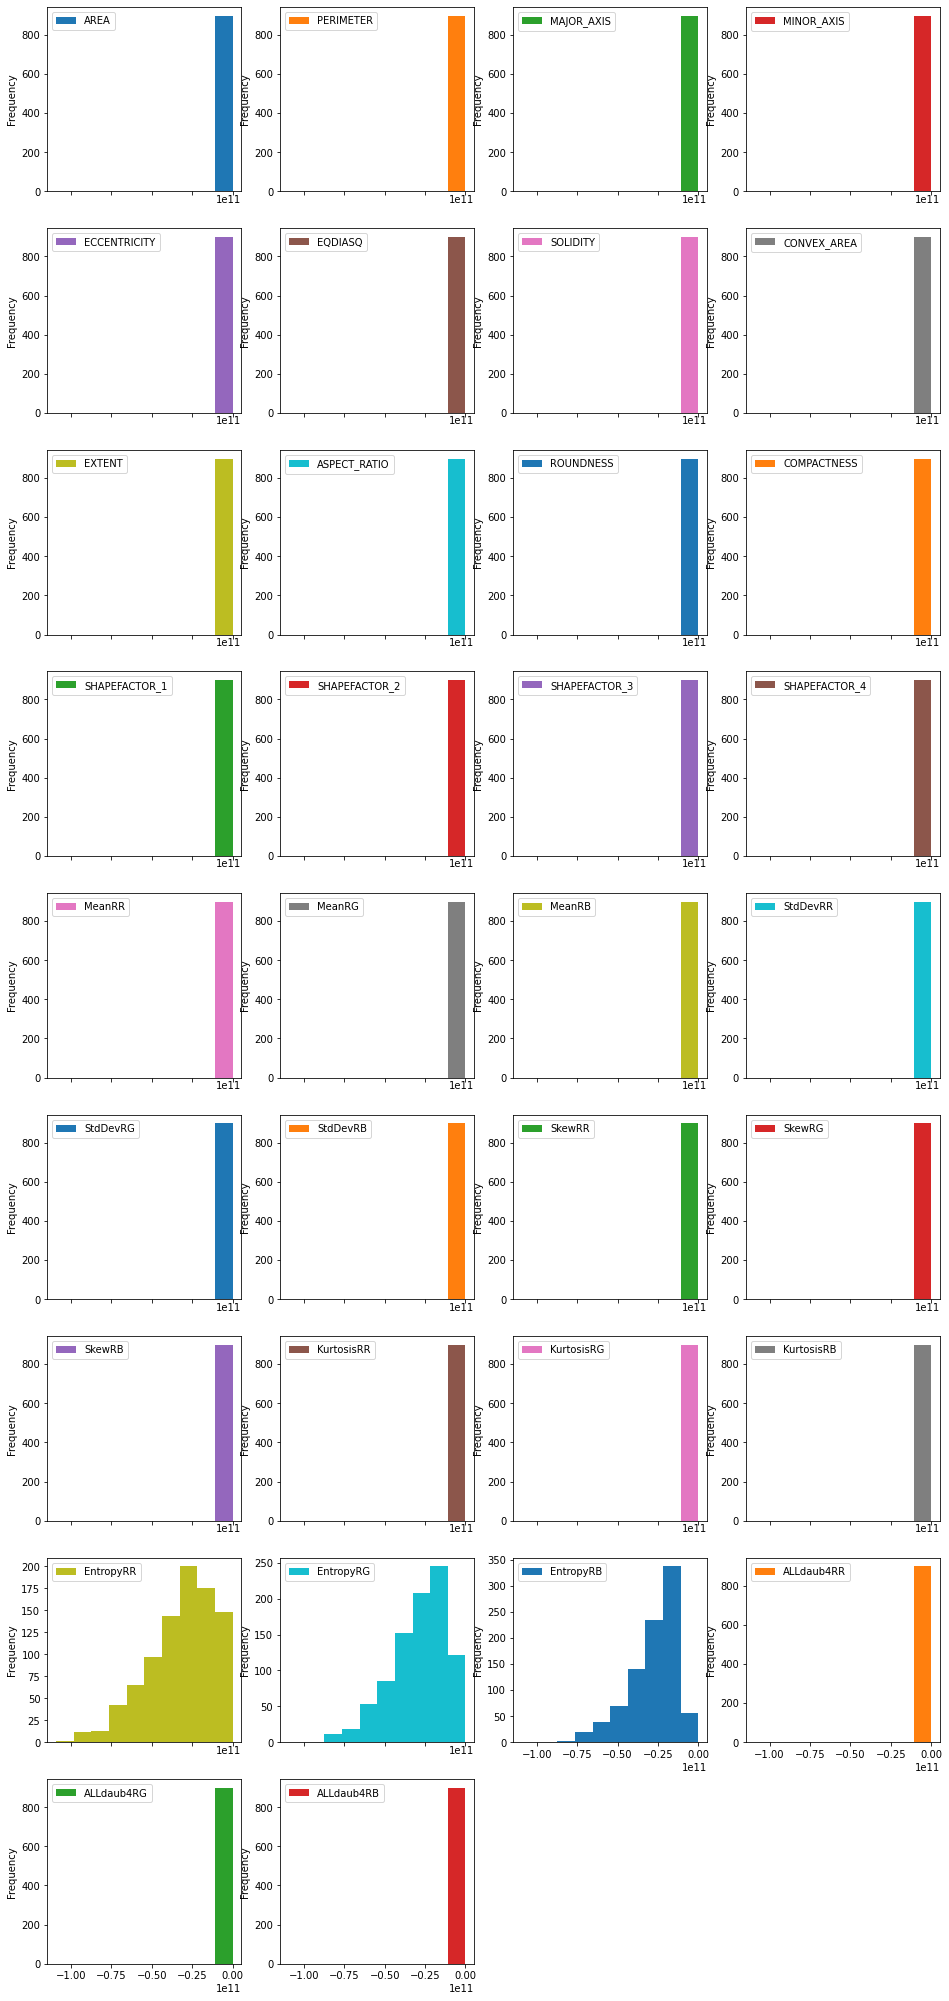

In [24]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

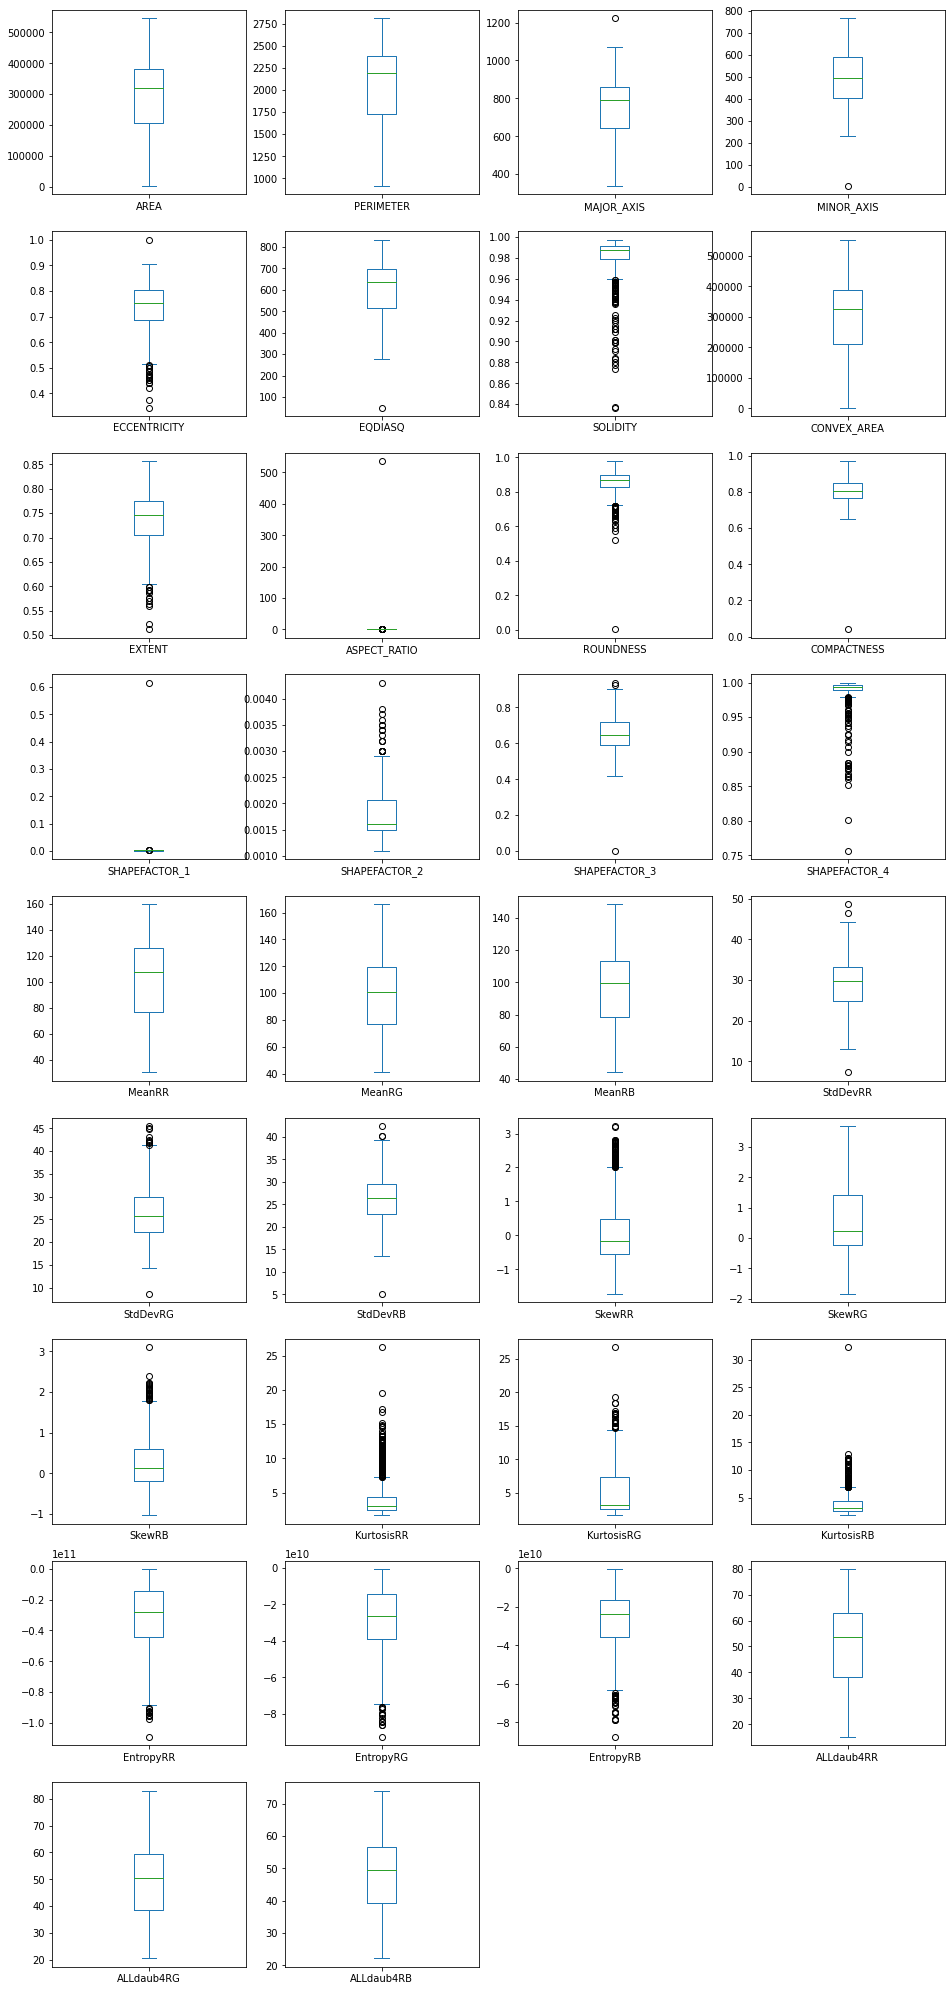

In [25]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

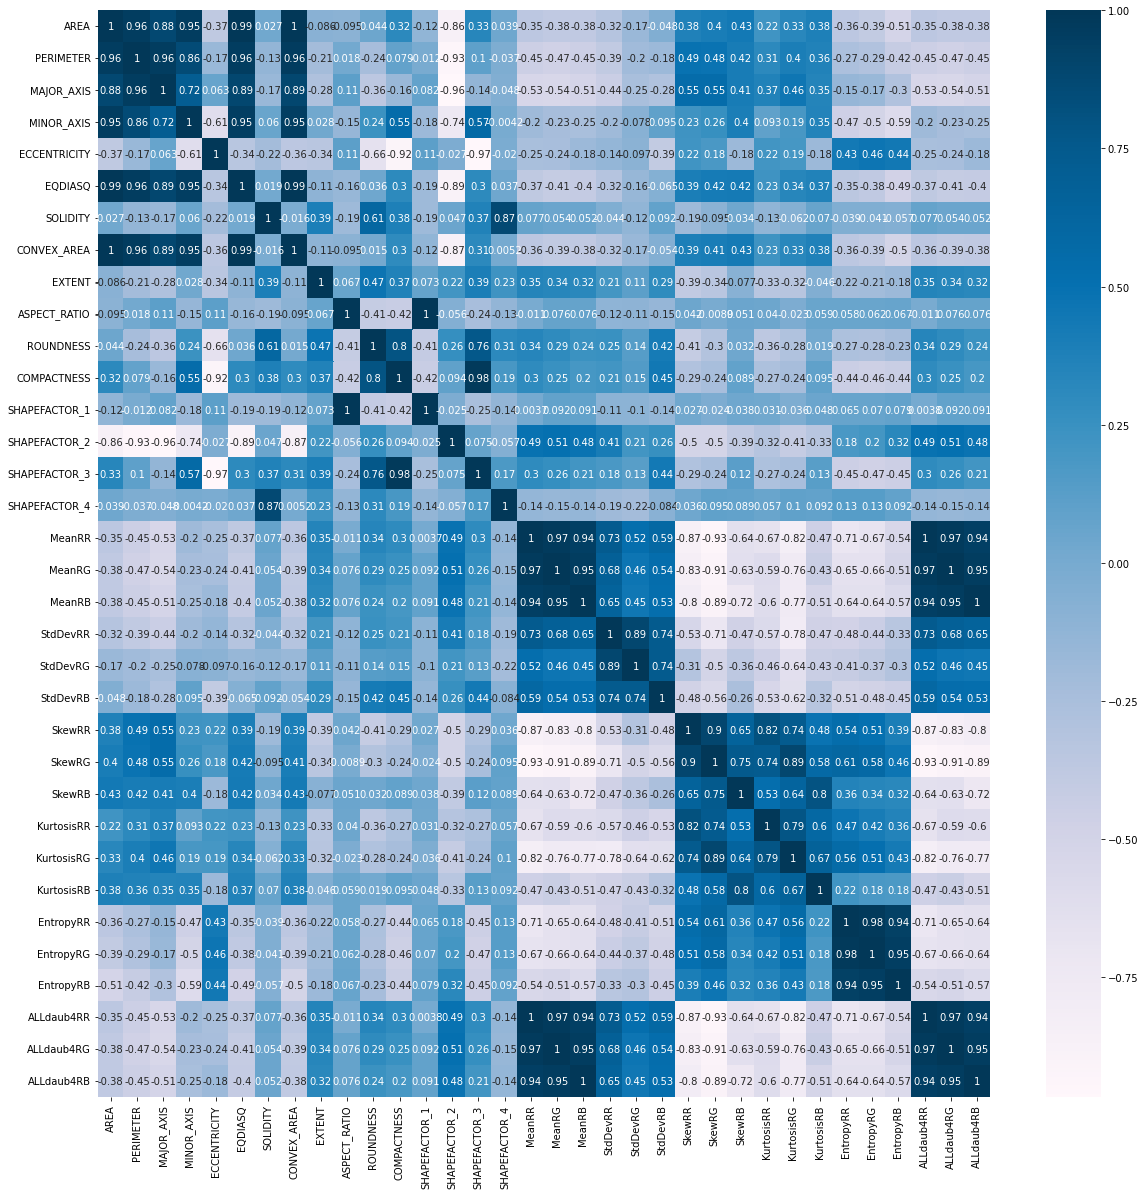

In [26]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [27]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [28]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling

In [29]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int','float']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="constant", fill_value=0)),
    ('scaler', preprocessing.StandardScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 34
Number of categorical columns: 0
Total number of columns in the feature dataframe: 34


In [30]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
    ], remainder='passthrough')

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (898, 34) to array_features_train.shape: (898, 34)


### 3.b) Training Data Balancing

In [31]:
# Not applicable for this iteration of the project

### 3.c) Feature Selection

In [32]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [33]:
# Finalize the training dataset for the modeling activities
label_encoder = preprocessing.LabelEncoder()
array_target_train = keras.utils.to_categorical(label_encoder.fit_transform(df_target_train))
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (898, 34) array_target_train.shape: (898, 7)


In [34]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Tune Models

In [35]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [36]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=array_features_train.shape[1], output_param=NUM_CLASSES,
                    layer1_nodes=512, layer2_nodes=512, layer3_nodes=512, layer4_nodes=512, layer5_nodes=256,
                    layer1_dropout=0.25, layer2_dropout=0.25, layer3_dropout=0.25, layer4_dropout=0.25, layer5_dropout=0,
                    classifier_activation=CLASSIFIER_ACTIVATION,
                    loss_param=DEFAULT_LOSS, opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    nn_model = keras.Sequential([
        keras.layers.Dense(layer1_nodes, input_shape=(input_param,), activation='relu'),
        keras.layers.Dropout(layer1_dropout),
        keras.layers.Dense(layer2_nodes, activation='relu'),
        keras.layers.Dropout(layer2_dropout),
        keras.layers.Dense(layer3_nodes, activation='relu'),
        keras.layers.Dropout(layer3_dropout),
        keras.layers.Dense(layer4_nodes, activation='relu'),
        keras.layers.Dropout(layer4_dropout),
        keras.layers.Dense(layer5_nodes, activation='relu'),
        keras.layers.Dropout(layer5_dropout),
        keras.layers.Dense(output_param, activation=classifier_activation)
    ])
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [37]:
# Initialize the default model and get a baseline result
start_time_module = datetime.now()
results = list()
iteration = 0
cv = RepeatedKFold(n_splits=N_FOLDS, n_repeats=N_ITERATIONS, random_state=RNG_SEED)
for train_ix, val_ix in cv.split(array_features_train):
    feature_train, feature_validation = array_features_train[train_ix], array_features_train[val_ix]
    target_train, target_validation = array_target_train[train_ix], array_target_train[val_ix]
    tf.keras.utils.set_random_seed(RNG_SEED)
    baseline_model = create_nn_model()
    baseline_model.fit(feature_train, target_train, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, verbose=0)
    model_metric = baseline_model.evaluate(feature_validation, target_validation, verbose=0)[1]
    iteration = iteration + 1
    print('Score from iteration %d >>> %.4f' % (iteration, model_metric))
    results.append(model_metric)
validation_score = np.mean(results)
validation_variance = np.std(results)
print('Average model score from all iterations: %.4f (%.4f)' % (validation_score, validation_variance))
print('Total time for model fitting and cross validating:', (datetime.now() - start_time_module))

Score from iteration 1 >>> 0.9111
Score from iteration 2 >>> 0.9778
Score from iteration 3 >>> 1.0000
Score from iteration 4 >>> 0.9333


Score from iteration 5 >>> 0.9111


Score from iteration 6 >>> 0.8667
Score from iteration 7 >>> 0.9556
Score from iteration 8 >>> 0.9333
Score from iteration 9 >>> 0.8876
Score from iteration 10 >>> 0.9101
Average model score from all iterations: 0.9287 (0.0384)
Total time for model fitting and cross validating: 0:00:34.055500


### 4.b) Algorithm Tuning

In [38]:
# Not applicable for this iteration of modeling

In [39]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [40]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [41]:
FINAL_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
tf.keras.utils.set_random_seed(RNG_SEED)
final_model = create_nn_model(opt_param=FINAL_OPTIMIZER)
final_model.fit(array_features_train, array_target_train, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, verbose=0)
final_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 512)               17920     
                                                                 
 dropout_50 (Dropout)        (None, 512)               0         
                                                                 
 dense_61 (Dense)            (None, 512)               262656    
                                                                 
 dropout_51 (Dropout)        (None, 512)               0         
                                                                 
 dense_62 (Dense)            (None, 512)               262656    
                                                                 
 dropout_52 (Dropout)        (None, 512)               0         
                                                                 
 dense_63 (Dense)            (None, 512)             

In [42]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [43]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 0:00:54.170377
